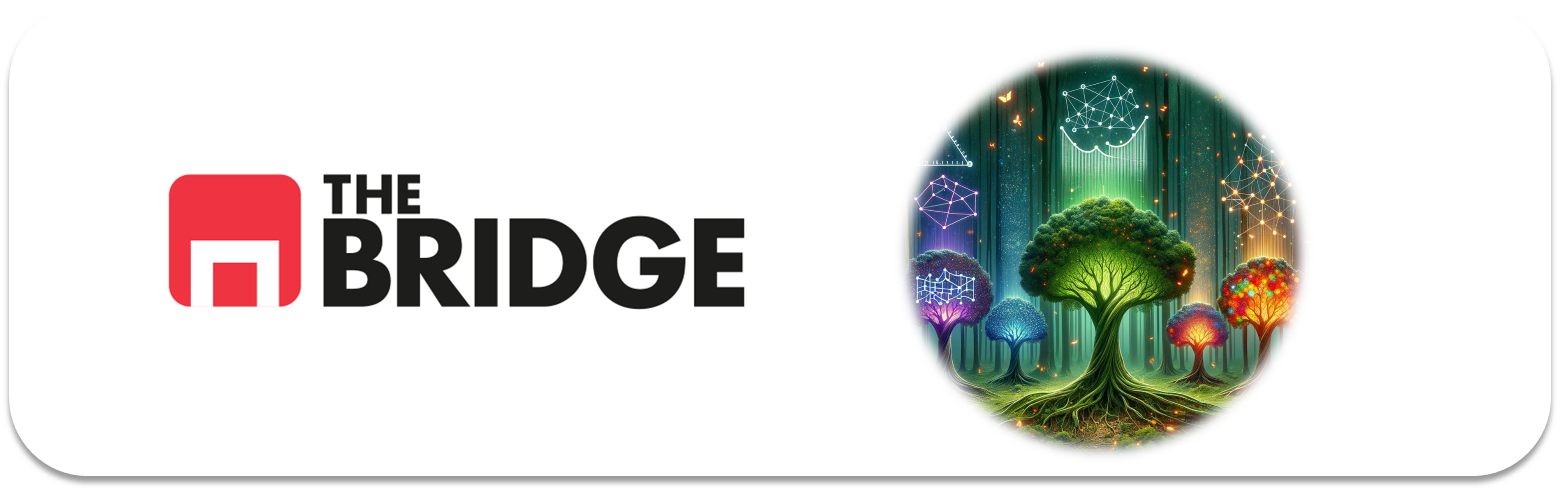

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [126]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from math import sqrt
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pprint import pprint
from sklearn.metrics import roc_curve, auc
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [102]:
df = pd.read_csv("./data/bank-full.csv", sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [103]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


La variable target es y.

In [104]:
#cambio el nombre de la variable target y por balance
df = df.rename(columns={'y': 'balance'})
#elimino columnas que no me interesan
df = df.drop(['job', 'contact', 'poutcome'], axis=1)
df

,age,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,balance
0,58,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no
1,44,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no
2,33,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no
3,47,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,no
4,33,single,unknown,no,1,no,no,5,may,198,1,-1,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,married,tertiary,no,825,no,no,17,nov,977,3,-1,0,yes
45207,71,divorced,primary,no,1729,no,no,17,nov,456,2,-1,0,yes
45208,72,married,secondary,no,5715,no,no,17,nov,1127,5,184,3,yes
45209,57,married,secondary,no,668,no,no,17,nov,508,4,-1,0,no


In [105]:
#convierto los string a int
df['default'] = df['default'].replace({'yes': 1, 'no': 0})
df['balance'] = df['balance'].replace({'yes': 1, 'no': 0})
df['loan'] = df['loan'].replace({'yes': 1, 'no': 0})
df['housing'] = df['housing'].replace({'yes': 1, 'no': 0})
df['marital'] = df['marital'].replace({'married': 1, 'single': 0, 'divorced': 2})
df['education'] = df['education'].replace({'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3})
df['month'] = df['month'].replace({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})


In [106]:
df.head()


,age,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,balance
0,58,1,3,0,2143,1,0,5,5,261,1,-1,0,0
1,44,0,2,0,29,1,0,5,5,151,1,-1,0,0
2,33,1,2,0,2,1,1,5,5,76,1,-1,0,0
3,47,1,0,0,1506,1,0,5,5,92,1,-1,0,0
4,33,0,0,0,1,0,0,5,5,198,1,-1,0,0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   marital    45211 non-null  int64
 2   education  45211 non-null  int64
 3   default    45211 non-null  int64
 4   balance    45211 non-null  int64
 5   housing    45211 non-null  int64
 6   loan       45211 non-null  int64
 7   day        45211 non-null  int64
 8   month      45211 non-null  int64
 9   duration   45211 non-null  int64
 10  campaign   45211 non-null  int64
 11  pdays      45211 non-null  int64
 12  previous   45211 non-null  int64
 13  balance    45211 non-null  int64
dtypes: int64(14)
memory usage: 4.8 MB


C:\Users\estel\AppData\Local\Temp\ipykernel_16944\1947307053.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["balance"])


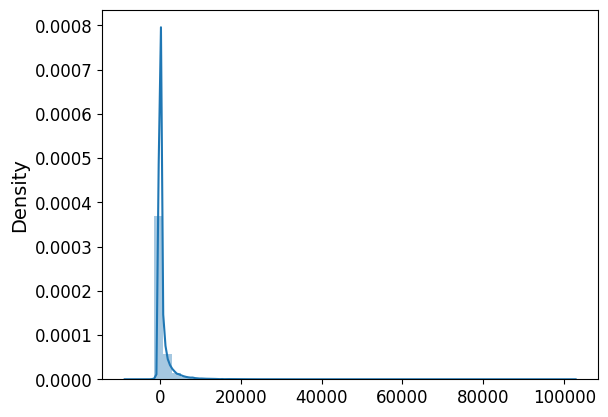

In [108]:
#grafica de balance
sns.distplot(df["balance"])
plt.show()

In [109]:
#separamos la variable target balance de las variables independientes en dos dataframes
#x tendra la variable target, y tendra las variables independientes
X = df.drop('balance', axis=1)
y = df['balance']

In [110]:
#dividimos los datos en dos conjuntos: entrenamiento/train (80%) y prueba/set (20%)
#crearemos cuatro dataframes:
#x_train contiene las variables independientes de entrenamiento
#x_test contiene las variables independientes de prueba
#y_train contiene la variable target de entrenamiento
#y_test contiene la variable target de prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'marital'}>,
        <Axes: title={'center': 'education'}>],
       [<Axes: title={'center': 'default'}>,
        <Axes: title={'center': 'housing'}>,
        <Axes: title={'center': 'loan'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

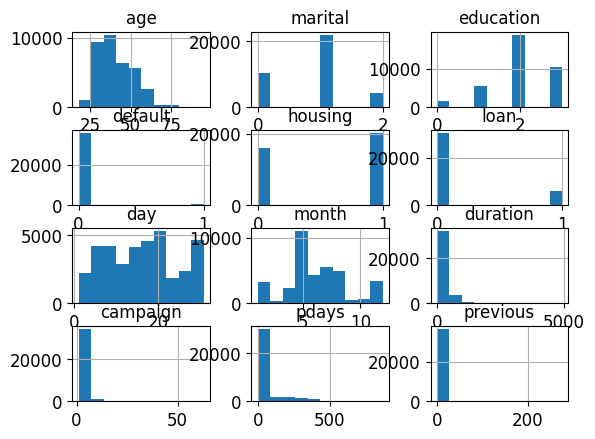

In [111]:
X_train.hist()


In [112]:
X_train.describe()


,age,marital,education,default,housing,loan,day,month,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.930823,0.831951,2.057979,0.018718,0.556708,0.161330,15.817739,6.147202,256.891202,2.765649,40.180076,0.580264
std,10.618369,0.607385,0.776828,0.135530,0.496781,0.367841,8.325860,2.410578,256.884103,3.120193,100.107617,2.370668
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,1.000000,2.000000,0.000000,1.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1.000000,3.000000,0.000000,1.000000,0.000000,21.000000,8.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,2.000000,3.000000,1.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,63.000000,871.000000,275.000000


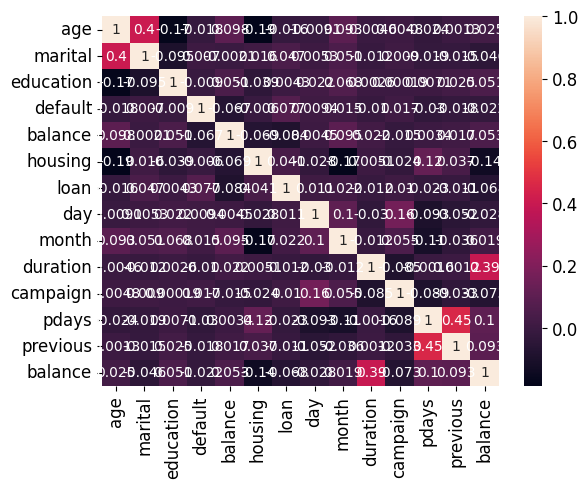

In [113]:
#hacemos un mapa de calor para ver la correlacion
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

In [123]:
#ajustamos un modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

#evaluamos el rendimiento del modelo en el conjunto de prueba
score = model.score(X_test, y_test)
print('Accuracy:', score)

Accuracy: 1.0


c:\Users\estel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El modelo ha predicho correctamente todas las muestras del conjunto de la prueba.

In [131]:
#definimos los valores de los hiperparámetros a probar
param_grid = {'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 6]}

#creamos un modelo de árbol de decisión de regresión
model = DecisionTreeRegressor()

#buscamos los mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)

#evaluamos el rendimiento del modelo en el conjunto de prueba
score = grid_search.score(X_test, y_test)
print('Accuracy:', score)

Best parameters: {'max_depth': 2, 'min_samples_split': 4}
Accuracy: 0.9416716853615607


El árbol tendrá como máximo 2 niveles de nodos y se necesitan mínimo 4 muestras para dividir el nodo interno.

In [132]:
#ajustamos el modelo baseline de árbol de decisión de regresión
baseline_model = DecisionTreeRegressor()
baseline_model.fit(X_train, y_train)

#evaluamos el rendimiento del modelo baseline en el conjunto de prueba
baseline_score = baseline_model.score(X_test, y_test)
print('Baseline accuracy:', baseline_score)

#ajustamos el modelo de árbol de decisión de regresión optimizado
optimized_model = DecisionTreeRegressor(max_depth=5, min_samples_split=2)
optimized_model.fit(X_train, y_train)

#evaluamos el rendimiento del modelo optimizado en el conjunto de prueba
optimized_score = optimized_model.score(X_test, y_test)
print('Optimized accuracy:', optimized_score)

Baseline accuracy: 1.0
Optimized accuracy: 1.0


In [134]:
#ajustamos un modelo de árbol de decisión de regresión
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

#evaluamos el rendimiento del modelo en el conjunto de prueba
score = model.score(X_test, y_test)
print('Accuracy:', score)

Accuracy: 1.0
